In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

### Import Libraries

In [2]:
from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf
from tensorflow import keras

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

### Explore Data

Number of Images for Training:  108309
Number of Images for validating:  1000
Number of classes:  4


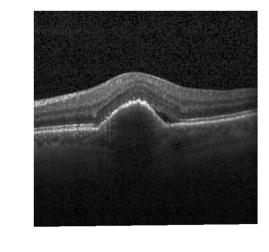

In [3]:
# Explore Data
cwd = os.getcwd()
PATH = os.path.join(cwd, 'OCT')
train_path = os.path.join(PATH, 'train')
valid_path = os.path.join(PATH, 'test')

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
print("Number of Images for Training: ",len(image_files))
print("Number of Images for validating: ",len(glob(valid_path + '/*/*.jp*g')))
# useful for getting number of classes
folders = glob(train_path + '/*')
print("Number of classes: ",len(folders))

# look at an image for fun
plt.imshow(keras.utils.load_img(np.random.choice(image_files)))

plt.show()

In [4]:
# re-size all the images to 100x100
IMAGE_SIZE = [100, 100] 

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

### Loss and Optimization functions

In [5]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

Found 1000 images belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
min: -123.68 max: 133.46005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


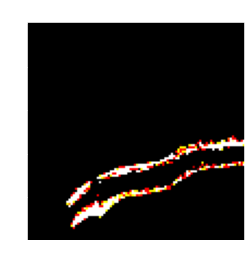

In [6]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [7]:
# training config:
epochs = 5
batch_size = 100

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Found 108309 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


C:\Users\LABILK~1\AppData\Local\Temp/ipykernel_12012/502453524.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
1083/1083 [==============================] - 2019s 2s/step - loss: 3.1161 - accuracy: 0.7035 - val_loss: 3.5558 - val_accuracy: 0.6190
Epoch 2/5
1083/1083 [==============================] - 2015s 2s/step - loss: 2.6718 - accuracy: 0.7360 - val_loss: 5.9552 - val_accuracy: 0.6150
Epoch 3/5
1083/1083 [==============================] - 2010s 2s/step - loss: 2.6336 - accuracy: 0.7397 - val_loss: 7.2075 - val_accuracy: 0.6140
Epoch 4/5
1083/1083 [==============================] - 2017s 2s/step - loss: 2.6327 - accuracy: 0.7416 - val_loss: 3.5207 - val_accuracy: 0.6630
Epoch 5/5
1083/1083 [==============================] - 1946s 2s/step - loss: 2.6197 - accuracy: 0.7456 - val_loss: 3.9236 - val_accuracy: 0.6530


In [8]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)




Generating confusion matrix 108309
Found 108309 images belonging to 4 classes.
7/7 [==============================] - 4s 509ms/step
50
7/7 [==============================] - 4s 511ms/step
100
7/7 [==============================] - 4s 497ms/step
150
7/7 [==============================] - 3s 463ms/step
200
7/7 [==============================] - 3s 465ms/step
250
7/7 [==============================] - 4s 500ms/step
300
7/7 [==============================] - 4s 511ms/step
350
7/7 [==============================] - 3s 467ms/step
400
7/7 [==============================] - 3s 468ms/step
450
7/7 [==============================] - 3s 467ms/step
500
4/4 [==============================] - 2s 430ms/step
[[34181   431  1050  1543]
 [ 2862  3596   602  4288]
 [ 3145   135  2035  3301]
 [ 2770   725  2056 45589]]
Generating confusion matrix 1000
Found 1000 images belonging to 4 classes.
7/7 [==============================] - 3s 466ms/step
[[239   2   3   6]
 [ 59 136   3  52]
 [ 83   9  62  96]
 [  5

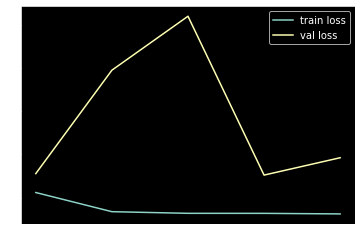

KeyError: 'acc'

In [9]:
# plot Loss and Accuracies

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()


Confusion matrix, without normalization
[[28693  1096  4306  3110]
 [ 1337  3434  1122  5455]
 [ 1340   171  3248  3857]
 [  827   790  3163 46360]]


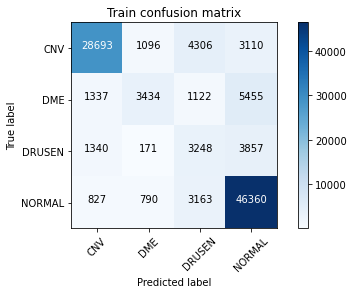

Confusion matrix, without normalization
[[218   9   9  14]
 [ 34 123  15  78]
 [ 38   5  83 124]
 [  2   4  17 227]]


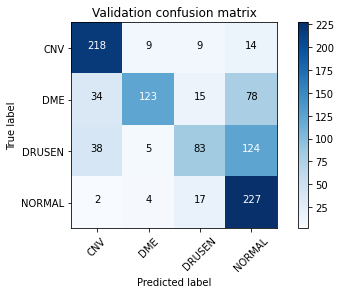

In [ ]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')